In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

Preprocessing

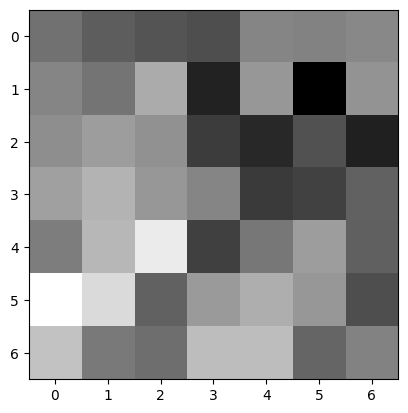

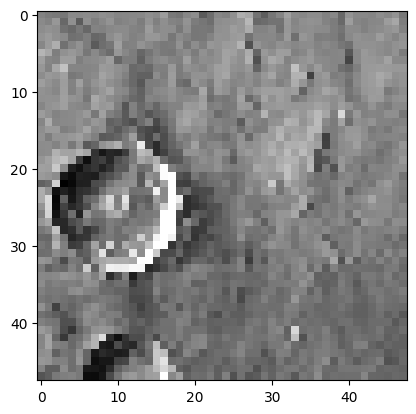

In [23]:
# Load data
Xtrain2_a = np.load('Xtrain2_a.npy')
Xtrain2_b = np.load('Xtrain2_b.npy')
Ytrain2_a = np.load('Ytrain2_a.npy')
Ytrain2_b = np.load('Ytrain2_b.npy')
Xtest2_a = np.load('Xtest2_a.npy')
Xtest2_b = np.load('Xtest2_b.npy')

# Visualize first sample of each training data set
plt.figure()
plt.imshow(Xtrain2_a[0].reshape((7,7)), cmap='gray')
plt.figure()
plt.imshow(Xtrain2_b[0].reshape((48,48)), cmap='gray')

In [24]:
# Check dimensions
print(Xtrain2_a.shape)
print(Ytrain2_a.shape)
print(Xtrain2_b.shape)
print(Ytrain2_b.shape)
print(547*2304)
print(1260288-547*(3*48*2+3*42*2))

(964908, 49)
(964908,)
(547, 2304)
(547, 2304)
1260288
964908


In [25]:
# Ytrain contains 0 and 255, should be 0 and 1
print("Original unique values:", np.unique(Ytrain2_a))
Ytrain2_a = np.where(Ytrain2_a == 255, 1, Ytrain2_a)
print("Original unique values:", np.unique(Ytrain2_a))
print("Original unique values:", np.unique(Ytrain2_b))
Ytrain2_b = np.where(Ytrain2_b == 255, 1, Ytrain2_b)
print("Original unique values:", np.unique(Ytrain2_b))

Original unique values: [  0. 255.]
Original unique values: [0. 1.]
Original unique values: [  0. 255.]
Original unique values: [0. 1.]


In [26]:
# Scale data from [0,255] to [0,1]
train_images2_a = (Xtrain2_a).astype('float32')/255.0
# Get label vectors
#train_labels2_a = keras.utils.to_categorical(Ytrain2_a,2)
# Split into training and validation set
X_train, X_val, y_train, y_val = train_test_split(train_images2_a, Ytrain2_a, test_size=0.2)

In [27]:
#y_temp = np.argmax(y_train, axis=1)

In [28]:
# Find out what class to create more training data for
crater = X_train[np.where(y_train == 1)]
no_crater = X_train[np.where(y_train == 0)]
print(crater.shape)
print(no_crater.shape)
n = no_crater.shape[0]-crater.shape[0]
# Number of extra crater images to create
print(n)

(252273, 49)
(519653, 49)
267380


In [29]:
# Create an instance of ImageDataGenerator with various augmentations
def transform(image):
    # Randomly choose an action: flip, rotate, or copy
    action = np.random.choice(['flip', 'rotate', 'copy'])    
    if action == 'flip':
        if np.random.rand() > 0.5:
            return np.fliplr(image)  # Flip horizontally
        else:
            return np.flipud(image)  # Flip vertically           
    elif action == 'rotate':
        rotation = np.random.choice([90, 180, 270])
        if rotation == 90:
            return np.rot90(image, k=1)  # Rotate 90 degrees
        elif rotation == 180:
            return np.rot90(image, k=2)  # Rotate 180 degrees
        elif rotation == 270:
            return np.rot90(image, k=3)  # Rotate 270 degrees        
    return image
datagen = ImageDataGenerator(
    preprocessing_function=transform
)

augmented_images = []

# Loop through training images
for img in crater:
    img_reshaped = img.reshape((7, 7, 1))
    x = np.expand_dims(img_reshaped, axis=0)  # Expand dims to make it a batch of 1

    # Generate augmented images
    for batch in datagen.flow(x, batch_size=1):
        # Flatten the augmented image
        np_array = batch[0].flatten()
        augmented_images.append(np_array)
        if len(augmented_images) >= n:  # Stop if you have enough augmented images
            break
    if len(augmented_images) >= n:
        break
# Convert to NumPy array
augmented_images = np.array(augmented_images)/255.0
print(augmented_images.shape)


(267380, 49)


In [30]:
y_train.shape

(771926,)

In [31]:
# Add augmented data to training set
y_augmented_images = np.ones(len(augmented_images))
#y_augmented_labels = keras.utils.to_categorical(y_augmented_images)
y_train = np.concatenate((y_train,y_augmented_images))
X_train = np.concatenate((X_train, augmented_images), axis=0)
X_train.shape, y_train.shape

((1039306, 49), (1039306,))

Set up CNN model

In [32]:
# Set up the model
model_CNN = Sequential()
model_CNN.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(7, 7, 1)))
#model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
#model_CNN.add(Dropout(0.5))
model_CNN.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#model_CNN.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
#model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
#model_CNN.add(Dropout(0.5))
#model_CNN.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model_CNN.add(Flatten())
model_CNN.add(Dense(64, activation='relu'))
#model_CNN.add(Dropout(0.3))
model_CNN.add(Dense(1, activation='sigmoid'))

# Define the balanced accuracy metric
def balanced_accuracy(y_true, y_pred):
    #y_true = tf.argmax(y_true, axis=1)
    #y_pred = tf.argmax(y_pred, axis=1)
    # Compute confusion matrix
    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)
    tp = tf.cast(cm[1, 1], tf.float32)  # True Positive
    tn = tf.cast(cm[0, 0], tf.float32)  # True Negative
    fp = tf.cast(cm[0, 1], tf.float32)  # False Positive
    fn = tf.cast(cm[1, 0], tf.float32)  # False Negative
    # True Positive Rate
    sensitivity = tp / (tp + fn + tf.keras.backend.epsilon())
    # True Negative Rate
    specificity = tn / (tn + fp + tf.keras.backend.epsilon())
    return (sensitivity + specificity) / 2  # Average of both rates

# Compile the model
model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', balanced_accuracy])

# Summary of the model
model_CNN.summary()

# Reshape X_train and X_val to (num_samples, 7, 7, 1)
X_train = X_train.reshape(-1, 7, 7, 1)
X_val = X_val.reshape(-1, 7, 7, 1)

# Fit the model 
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=5, min_lr=1e-6)

#callbacks=[reduce_lr, metrics, early_stopping]

history = model_CNN.fit(X_train, y_train, batch_size=64,
                         epochs=20,
                         validation_data=(X_val, y_val),
                         callbacks=[reduce_lr],
                         verbose=1)

c:\Users\j040c\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 5, 5, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,809 (218.00 KB)

 Trainable params: 55,809 (218.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
16240/16240 ━━━━━━━━━━━━━━━━━━━━ 95s 6ms/step - accuracy: 0.8101 - balanced_accuracy: 0.5000 - loss: 0.4084 - val_accuracy: 0.7613 - val_balanced_accuracy: 0.5000 - val_loss: 0.5333 - learning_rate: 0.0010
Epoch 2/20
16240/16240 ━━━━━━━━━━━━━━━━━━━━ 95s 6ms/step - accuracy: 0.8252 - balanced_accuracy: 0.5000 - loss: 0.3790 - val_accuracy: 0.7691 - val_balanced_accuracy: 0.5000 - val_loss: 0.5001 - learning_rate: 0.0010
Epoch 3/20
16240/16240 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - accuracy: 0.8303 - balanced_accuracy: 0.5000 - loss: 0.3695 - val_accuracy: 0.7742 - val_balanced_accuracy: 0.5000 - val_loss: 0.4928 - learning_rate: 0.0010
Epoch 4/20
16240/16240 ━━━━━━━━━━━━━━━━━━━━ 85s 5ms/step - accuracy: 0.8327 - balanced_accuracy: 0.5000 - loss: 0.3646 - val_accuracy: 0.7718 - val_balanced_accuracy: 0.5000 - val_loss: 0.4989 - learning_rate: 0.0010
Epoch 5/20
16240/16240 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - accuracy: 0.8355 - balanced_accuracy: 0.5000 - loss: 0.3600 - val_accurac

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=5, min_lr=1e-6)

history = model_CNN.fit(X_train, y_train, batch_size=64,
                         epochs=20,
                         validation_data=(X_val, y_val),
                         callbacks=[reduce_lr],
                         verbose=1)